In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


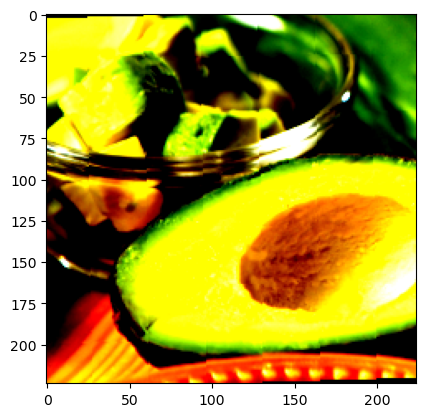

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 10
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


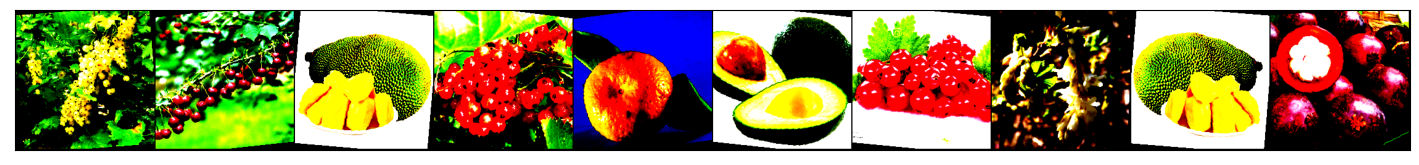

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*224*224
output_size = 55

In [16]:
from torchvision.models import mobilenet_v3_small

class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, num_classes):
        super(ConvolutionalNetwork, self).__init__()
        mobilenet_v3 = mobilenet_v3_small(pretrained=True)
        self.features = nn.Sequential(*list(mobilenet_v3.children())[:-1])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(576, num_classes)

        
    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\a1881044/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([10, 3, 224, 224])
out.shape: torch.Size([10, 55])
out[0]: tensor([-3.4985, -4.1879, -4.3746, -4.0564, -3.9226, -3.9461, -4.4258, -3.7827,
        -3.9676, -4.1381, -4.2720, -4.3514, -4.2962, -4.0561, -4.1249, -4.0437,
        -4.1803, -3.9755, -3.9947, -3.8883, -3.7010, -3.7543, -4.0400, -3.9347,
        -4.0261, -4.2464, -3.7694, -3.9318, -3.8276, -4.1773, -3.9822, -4.0058,
        -4.3784, -3.8962, -4.3218, -3.6153, -4.1325, -4.0859, -4.0030, -4.4167,
        -3.7548, -4.1198, -4.1808, -3.6561, -4.3121, -4.1723, -3.7892, -4.1403,
        -3.9816, -4.2579, -3.9988, -3.8872, -4.1003, -4.0627, -3.5866],
       grad_fn=<SelectBackward0>)


In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Co

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 4.04888391494751, 'val_acc': 0.06521739810705185}]

In [23]:
print(test_size)
num_epochs = 35
opt_func = torch.optim.SGD
lr = 0.001

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9263, val_loss: 3.7674, val_acc: 0.2572


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.6791, val_loss: 3.4911, val_acc: 0.4522


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.4307, val_loss: 3.1928, val_acc: 0.5565


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.1617, val_loss: 2.8774, val_acc: 0.6232


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9071, val_loss: 2.6050, val_acc: 0.6710


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.6704, val_loss: 2.3611, val_acc: 0.7225


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.4756, val_loss: 2.1729, val_acc: 0.7420


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3067, val_loss: 2.0087, val_acc: 0.7493


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.1745, val_loss: 1.8571, val_acc: 0.7833


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.0365, val_loss: 1.7571, val_acc: 0.7899


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.9449, val_loss: 1.6388, val_acc: 0.8029


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.8420, val_loss: 1.5787, val_acc: 0.8109


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.7643, val_loss: 1.5019, val_acc: 0.8203


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.7053, val_loss: 1.4404, val_acc: 0.8312


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.6318, val_loss: 1.3808, val_acc: 0.8565


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.5784, val_loss: 1.3348, val_acc: 0.8507


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.5377, val_loss: 1.3025, val_acc: 0.8674


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.4885, val_loss: 1.2546, val_acc: 0.8681


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.4545, val_loss: 1.2247, val_acc: 0.8761


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.4083, val_loss: 1.1922, val_acc: 0.8783


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.3712, val_loss: 1.1564, val_acc: 0.8790


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.3298, val_loss: 1.1414, val_acc: 0.8891


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.3114, val_loss: 1.1175, val_acc: 0.8870


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.2637, val_loss: 1.1053, val_acc: 0.8913


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.2484, val_loss: 1.0821, val_acc: 0.8957


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.2215, val_loss: 1.0601, val_acc: 0.8913


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.2112, val_loss: 1.0455, val_acc: 0.8913


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.1968, val_loss: 1.0376, val_acc: 0.9109


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.1591, val_loss: 1.0200, val_acc: 0.9022


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [29], train_loss: 1.1409, val_loss: 0.9943, val_acc: 0.9000


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [30], train_loss: 1.1184, val_loss: 0.9904, val_acc: 0.9051


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [31], train_loss: 1.0969, val_loss: 1.0002, val_acc: 0.9065


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [32], train_loss: 1.0824, val_loss: 0.9752, val_acc: 0.9065


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [33], train_loss: 1.0576, val_loss: 0.9649, val_acc: 0.9043


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [34], train_loss: 1.0514, val_loss: 0.9459, val_acc: 0.9065


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

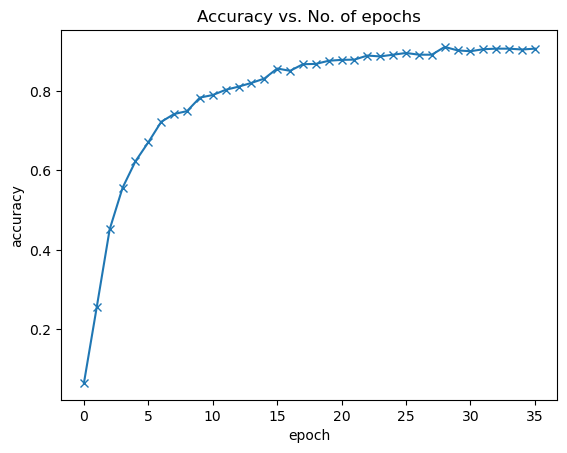

In [26]:
plot_accuracies(history)

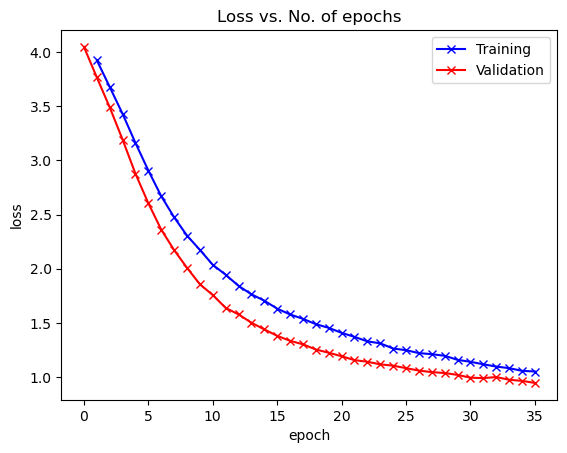

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 0.8687852025032043, 'val_acc': 0.9032608270645142}